# Content Retention and Longevity in Spotify Charts
## Exploratory Data Analysis (EDA)

**Objective**  
Analyze how long songs retain attention in Spotify charts and evaluate whether
audio features contain signal for predicting **content persistence**.

**Interpretation**
- Chart exit ≈ content churn
- `weeks_on_chart` ≈ retention duration
- Long-lived songs ≈ sticky content

**Constraints**
- No release dates or daily trajectories
- Retention approximated via chart persistence
- Focus on pattern discovery and robustness, not causal claims


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (7, 4)


## 1. Load dataset and inspect structure


In [3]:
DATA_PATH = r"D:\Data_analysis_BI\Project\Spotify\data\spotify_top_songs_audio_features.csv"

df = pd.read_csv(DATA_PATH)

df.head(5)




,id,artist_names,track_name,source,key,mode,time_signature,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,loudness,tempo,duration_ms,weeks_on_chart,streams
0,000xQL6tZNLJzIrtIgxqSl,"ZAYN, PARTYNEXTDOOR",Still Got Time (feat. PARTYNEXTDOOR),RCA Records Label,G,Major,4 beats,0.748,0.627,0.0639,0.13100,0.0,0.0852,0.524,-6.029,120.963,188491,17,107527761
1,003eoIwxETJujVWmNFMoZy,Alessia Cara,Growing Pains,Def Jam Recordings,C#/Db,Minor,4 beats,0.353,0.755,0.7330,0.08220,0.0,0.3900,0.437,-6.276,191.153,193680,2,9944865
2,003vvx7Niy0yvhvHt4a68B,The Killers,Mr. Brightside,Island Records,C#/Db,Major,4 beats,0.352,0.911,0.0747,0.00121,0.0,0.0995,0.236,-5.230,148.033,222973,125,512388123
3,00B7TZ0Xawar6NZ00JFomN,"Cardi B, Chance the Rapper",Best Life (feat. Chance The Rapper),Atlantic/KSR,A,Major,4 beats,0.620,0.625,0.5530,0.28700,0.0,0.3140,0.665,-7.438,167.911,284856,2,11985346
4,00Blm7zeNqgYLPtW6zg8cj,"Post Malone, The Weeknd",One Right Now (with The Weeknd),Republic Records,C#/Db,Major,4 beats,0.687,0.781,0.0530,0.03610,0.0,0.0755,0.688,-4.806,97.014,193507,30,301860377


In [4]:
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
df.columns


Rows: 6,513
Columns: 19


Index(['id', 'artist_names', 'track_name', 'source', 'key', 'mode',
       'time_signature', 'danceability', 'energy', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'loudness',
       'tempo', 'duration_ms', 'weeks_on_chart', 'streams'],
      dtype='object')

### Dataset scale

This dataset contains only songs that entered the Spotify Top 200 since 2016, representing
content that successfully competed for attention at least briefly.

## Missing Value Assessment

The dataset was examined for missing values across all columns.

All columns contain zero missing entries. This indicates that the dataset is structurally complete, with no explicit `NaN` values present.

It is important to note that the absence of `NaN` values does not necessarily imply the absence of missing information in a semantic sense. Certain variables may still encode missing or unknown information using placeholder values (e.g., zeros or default categories), which are not captured by standard missing-value checks.

Further validation steps focus on identifying such implicit missingness and verifying that all values fall within meaningful and expected ranges.

### Tracks vs creators

Multiple tracks per artist introduce creator-level effects,
analogous to studio or publisher effects in games.



In [5]:
df["id"].nunique(), df["artist_names"].nunique()


(6513, 3001)

In [6]:
(df.isna().sum()
   .sort_values(ascending=False)
   .loc[lambda x: x > 0])


Series([], dtype: int64)

## 2. Target variable: weeks_in_top_200

We treat chart persistence as a proxy for **content retention**.
Most songs churn quickly; a small fraction persist for many weeks.


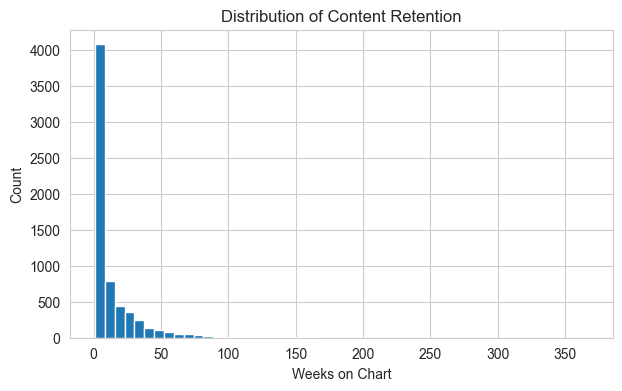

In [7]:
plt.hist(df["weeks_on_chart"], bins=50)
plt.xlabel("Weeks on Chart")
plt.ylabel("Count")
plt.title("Distribution of Content Retention")
plt.show()


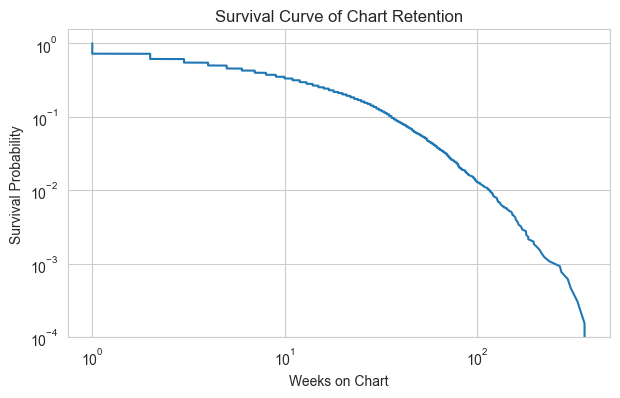

In [8]:
sorted_weeks = np.sort(df["weeks_on_chart"])
cdf = np.arange(1, len(sorted_weeks)+1) / len(sorted_weeks)

plt.plot(sorted_weeks, 1 - cdf)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Weeks on Chart")
plt.ylabel("Survival Probability")
plt.title("Survival Curve of Chart Retention")
plt.show()


Content retention exhibits a heavy-tailed survival distribution: most tracks exit the charts quickly, while a small minority persist for exceptionally long periods. This pattern mirrors retention dynamics observed in games and digital media platforms. As a result, log-scaled targets, rank-based evaluation metrics, and bucketed churn modeling are more appropriate than mean-based prediction. This behavior is empirically confirmed by the survival curve, which shows that only a small fraction of tracks retain chart presence over long time horizons.

## Implications for Modeling Strategy

The observed heavy-tailed survival distribution indicates that small differences in features can lead to large differences in observed retention.
As a result, predicting exact chart duration is unstable and sensitive to extreme outliers. We therefore shift from continuous prediction to
retention segmentation and rank-based analysis.

## Defining Retention Buckets (Churn vs Longevity)

Due to the heavy-tailed nature of chart retention, predicting exact weeks on chart is both unstable and poorly aligned with business decision-making.
Instead, we define discrete retention buckets that reflect meaningful content lifecycles:

- **Short-lived**: Rapid churn, minimal sustained attention
- **Mid-lived**: Moderate retention, some staying power
- **Long-lived**: Rare tracks with persistent cultural impact

This framing mirrors churn segmentation commonly used in media and gaming analytics.


In [9]:
# Inspect quantiles to define buckets
df["weeks_on_chart"].quantile([0.5, 0.75, 0.9, 0.95])


0.50     4.0
0.75    16.0
0.90    36.0
0.95    55.0
Name: weeks_on_chart, dtype: float64

In [10]:
def retention_bucket(weeks):
    if weeks <= 5:
        return "Short-lived"
    elif weeks <= 20:
        return "Mid-lived"
    else:
        return "Long-lived"

df["retention_bucket"] = df["weeks_on_chart"].apply(retention_bucket)

df["retention_bucket"].value_counts(normalize=True)


retention_bucket
Short-lived    0.545217
Mid-lived      0.253032
Long-lived     0.201750
Name: proportion, dtype: float64

<Figure size 600x400 with 0 Axes>

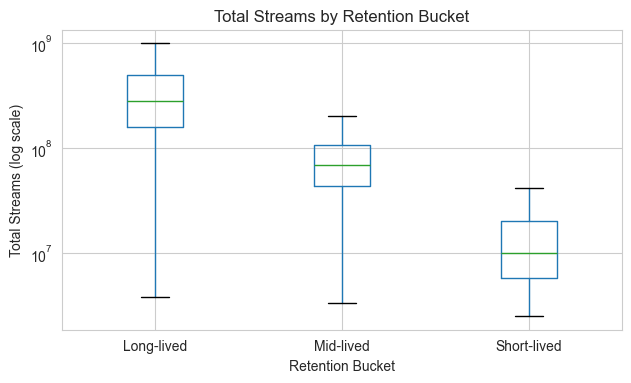

In [11]:
plt.figure(figsize=(6,4))
df.boxplot(column="streams", by="retention_bucket", showfliers=False)
plt.yscale("log")
plt.xlabel("Retention Bucket")
plt.ylabel("Total Streams (log scale)")
plt.title("Total Streams by Retention Bucket")
plt.suptitle("")
plt.show()


## Share of Total Streams by Retention Bucket

To quantify attention concentration, we compute the fraction of total streams
contributed by each retention bucket.


In [12]:
stream_share = (
    df.groupby("retention_bucket")["streams"].sum()
    / df["streams"].sum()
).sort_values(ascending=False)

stream_share


retention_bucket
Long-lived     0.719439
Mid-lived      0.202070
Short-lived    0.078491
Name: streams, dtype: float64

## Relationship Between Streams and Retention Duration

We examine the relationship between cumulative streams and weeks on chart
to assess whether they encode distinct or redundant information.


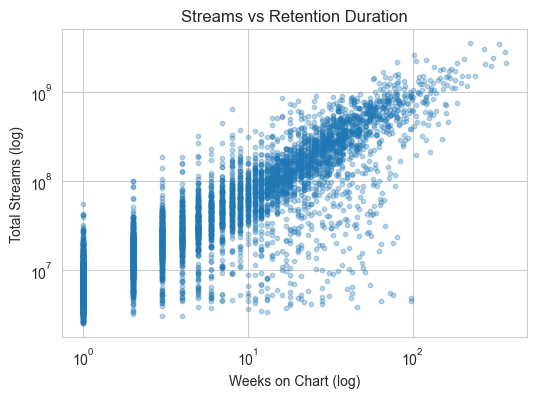

In [13]:
plt.figure(figsize=(6,4))
plt.scatter(
    df["weeks_on_chart"],
    df["streams"],
    alpha=0.3,
    s=10
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Weeks on Chart (log)")
plt.ylabel("Total Streams (log)")
plt.title("Streams vs Retention Duration")
plt.show()


The plot shows that tracks with longer chart retention generally accumulate more streams, but the relationship is not tight.
For the same number of weeks on the chart, total streams can differ by more than an order of magnitude.
This means that staying power and raw popularity are related, but not the same thing: some tracks spike quickly and fade, while others grow more slowly but persist longer.



## Artist Concentration Among Long-Lived Tracks

To assess whether long-term retention is driven by a small number of dominant artists,
we analyze how long-lived tracks are distributed across artists.


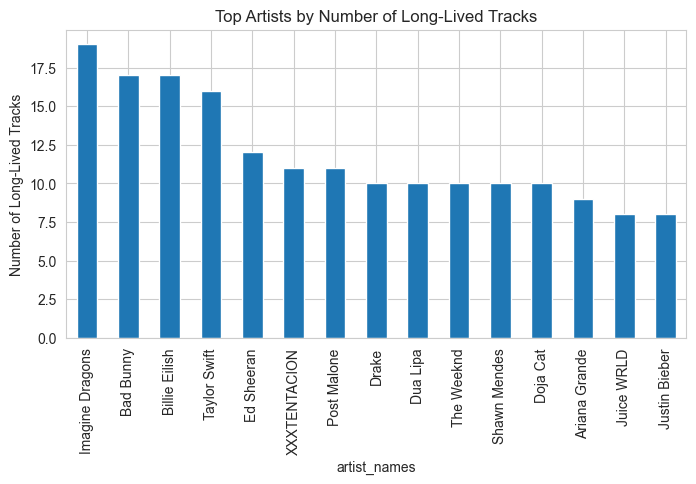

In [ ]:
long_lived = df[df["retention_bucket"] == "Long-lived"]

artist_counts = (
    long_lived["artist_names"]
    .value_counts()
    .head(15)
)


artist_counts.plot(kind="bar", figsize=(8,4))
plt.ylabel("Number of Long-Lived Tracks")
plt.title("Top Artists by Number of Long-Lived Tracks")
plt.show()



Longevity is not monopolized
  by a small number of creators, indicating that artist-level effects alone do not explain
  sustained chart presence.

## Comparison of Selected Audio Features Across Retention Buckets

After inspecting individual features, we summarize key audio characteristics
(danceability, valence, and acousticness) to compare their distributions
across retention outcomes.


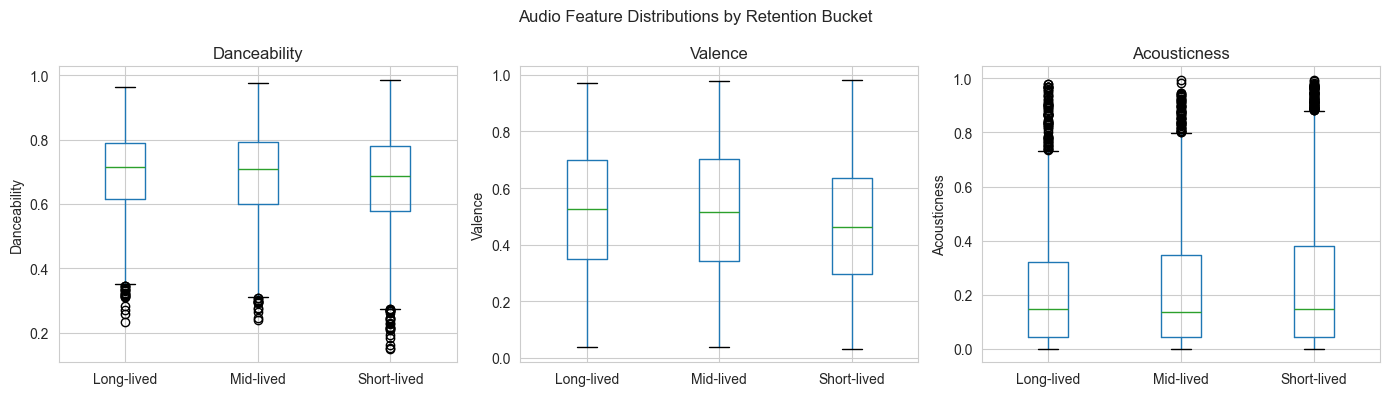

In [15]:
features_to_compare = ["danceability", "valence", "acousticness"]

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

for ax, feat in zip(axes, features_to_compare):
    df.boxplot(column=feat, by="retention_bucket", ax=ax)
    ax.set_title(feat.capitalize())
    ax.set_xlabel("")
    ax.set_ylabel(feat.capitalize())

plt.suptitle("Audio Feature Distributions by Retention Bucket")
plt.tight_layout()
plt.show()


Across multiple audio dimensions, feature distributions overlap substantially between retention groups, indicating that long-term success is not driven by any single audio characteristic but rather by weak, combined signals.

## EDA Summary and Key Takeaways

This exploratory analysis examined chart retention dynamics using Spotify Top 200 data,
focusing on retention duration, streams, audio features, and artist-level concentration.

Key findings:

- Chart retention exhibits a strongly heavy-tailed distribution: most tracks exit quickly,
  while a small fraction persist for exceptionally long periods.
- Total streams scale super-linearly with retention duration, indicating that longevity
  compounds exposure rather than merely reflecting initial popularity.
- Audio features such as danceability, acousticness, and valence show substantial overlap
  across retention groups, suggesting weak marginal effects when considered individually.
- Long-lived tracks show moderate artist concentration, but longevity is not monopolized
  by a small number of creators, indicating that artist-level effects alone do not explain
  sustained chart presence.

Overall, the EDA suggests that long-term success in music charts emerges from a combination
of factors rather than any single audio characteristic. This motivates formal statistical
testing and multivariate modeling to quantify whether and how audio features contribute
to retention and streaming outcomes beyond artist and exposure effects.
